In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
import gwnr
from pycbc.waveform import waveform_modes

import gwnr.waveform.enigma_utils as eu
import pycbc.conversions as convert
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#
from matplotlib.colors import ListedColormap

import matplotlib as mpl

 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt

In [2]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [3]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tshift_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e*q + A[6]*(e**2)*q + A[7]*(e)*math.cos(l + A[8]) + A[9]*(e**1)*(q**1)*math.cos(e*l + A[10]) + A[11]*(e**2)*math.cos(l + A[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tamp_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e*eta + B[6]*(e**2)*eta + B[7]*e*math.cos(l + B[8]) + B[9]*(e**1)*(eta**1)*math.cos(l + B[10]) + B[11]*(e**2)*math.cos(e*l + B[12])

g=open('/home/pratul/Downloads/Project/Analytical fits/New results/New_tfreq_H+modified_20hyb_Feb16.txt',"r") 

lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e*eta + C[6]*(e**2)*eta + C[7]*e*eta*math.cos(l + C[8]) + C[9]*(e)*math.cos(l + C[10]) + C[11]*(e**2)*math.cos(e*l + C[12])

In [4]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [5]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [153]:
def TT2_calc_mismatch(frefel,verbose=False):
    %run TaylorT2_Model.ipynb
    m=60
    
    distance=1
    sample_rate=4096
    dt=1/sample_rate
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    
    
    #hyb = ['1355','1356','1357','1358','1359','1360','1361','1362','1363','1364','1365','1366','1367','1368','1369','1370','1371','1372','1373','1374']
    
    #q0 = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3]

    #l0 = [1.423,1.574,0.451,-2.682,1.834,-0.395,-1.019,-0.507,-0.912,-0.181,-1.127,-2.890,1.687,0.420,-0.203,3.063,0.665,3.005,1.682,3.114]

    #e0 = [0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]

    #f0 = [16.53, 15.63, 13.74, 13.51, 13.92, 12.18, 11.95, 12.78, 11.62, 16.68, 15.72, 13.76, 13.84, 13.36, 12.87, 10.69, 15.94, 13.75, 13.74, 10.62]
    
    conv=(lal.G_SI*lal.MSUN_SI*m/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI) 

    #fref = fconv(0.03,m)
    
    h_str_NR=0
    
    #j = 0
    
    q=3  #q0[j]
    fref,e,l=frefel
    
    simulation = '/home/pratul/Downloads/Project/NR_data/'+'1372'+'_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
    sims = simulation.split('_')[0]
    lp = 2 #modes
    mp = 2
    tref = 640  # Varies depending on simulations
    mode = 'l'+str(lp)+'_m'+str(mp)
    with h5py.File(simulation, 'r') as hdf:
        temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
        test=np.array(temp)

    x1=test[:,0]
    y1=test[:,1]*(conv)    
    z1=test[:,2]*(conv)

    plotband=np.where(x1>=tref)

    x1=x1[plotband]
    x1=x1-x1[0]
    y1=y1[plotband]    
    z1=z1[plotband]


    delta_t_NR = dt

               
    Ylm=waveform_modes.get_glm(2, 2, 0)        
    
    hlm_tot_NR=y1+1j*z1
        
    h_str_NR += (hlm_tot_NR*Ylm)
    

    delta_t_common=delta_t_NR
    t=x1*m*MTSUN_SI
    
    hp_NR=h_str_NR.real
    hc_NR=-h_str_NR.imag
    
    # interpolation to sample data at equispaced time points
    
    tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
    hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR)
    hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
    hc_NR_int = hc_NR_sample(tVec_NR)

    
    hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
    hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)
    
    #itime=time.time()
    
    hplus_E,hcross_E,_ = TT2_MODEL22(m, q, e, l, fref, 0, distance, dt)
    #hplus_E,hcross_E,_ = Ecc_MODEL22(m, q, e, l, fref, 0, distance, dt)
    
    #print(hplus_E.real())
    hplus_E, hpVec_NR = waveform.utils.coalign_waveforms(hplus_E, hpVec_NR, psd=None, low_frequency_cutoff=None, high_frequency_cutoff=None, resize=True)
    
    
    tlen = max(len(hplus_E.sample_times), len(hpVec_NR))

    hplus_E.resize(tlen)
    
    hpVec_NR.resize(tlen)
    
    #dt=(40000*m*MTSUN_SI)
    #hplus_E = hplus_E.cyclic_time_shift(dt)
    #hpVec_NR = hpVec_NR.cyclic_time_shift(dt)
    
    # Generate the aLIGO ZDHP PSD
    
    delta_f = 1.0 / hplus_E.duration
    flen = tlen//2 + 1
    f_low = fref
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    ma, i = match(hplus_E, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
    mismatch = 1 - ma
    
    plt.figure(figsize=(12,2.5))
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 8
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 5
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 8
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 5
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    plt.plot(hpVec_NR.sample_times/(m*MTSUN_SI),hpVec_NR*mode2polfac/conv,label='SXS:BBH:1372 (training)',linewidth=4,color='navajowhite')
    plt.plot(hplus_E.sample_times/(m*MTSUN_SI),hplus_E/conv,label='TT2 Model',color='maroon',linestyle='--')
    plt.xlim(-50,5000)
    
    #plt.text(800, 0.08, r'$q$ = '+str(round(q,2)), color='black', fontsize=12)
    #plt.text(1600, 0.08, r'$e$ = '+str(round(e,3)), color='black', fontsize=12)
    #plt.text(0,0.08, 'Sim = 0246', color='black', fontsize=12)
    plt.text(4000,0.05, r'$\mathcal{M}$ = '+str(round(100*ma,2))+'\%', color='black', fontsize=12)
    #plt.minorticks_on(direction='in')
    plt.legend(fontsize = 12,loc='lower right',frameon=False)
    plt.ylabel(r'$h_+$',fontsize=15)
    plt.xlabel(r'$t/M$',fontsize=15)
#     plt.tick_params( 
#                 labelbottom = False) 
    #plt.xticks([1000,2000,3000,4000])
    plt.tight_layout()
    ##plt.savefig('/home/pratul/Downloads/Project/Plots_draft/'+'TT2_NR_Comp'+'1372'+'.pdf',dpi=300)
    return(mismatch*100)

3.3146895488045613

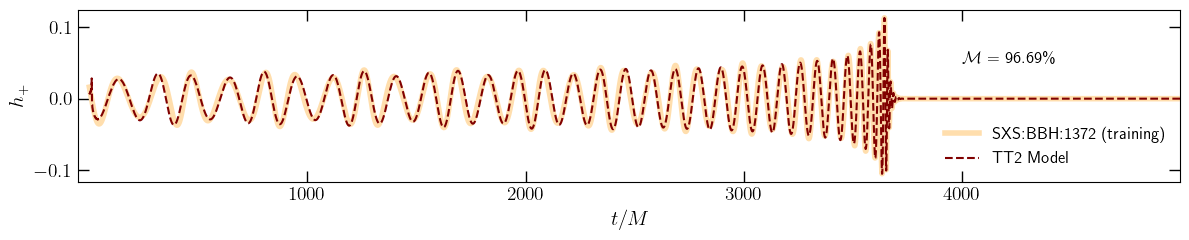

In [154]:
TT2_calc_mismatch([20.061183082949327, 0.081832591319223, 2.462129921478257])

In [50]:
?plt.minorticks_on()

Object `plt.minorticks_on()` not found.


In [153]:
xconv(16.187727284713387,60)

0.06090098987982968

### Generating random sets and finding the pair for lowest mismatch

In [154]:
fconv(0.06090098987982968,120)

8.093863642356697

In [113]:
ecc=np.random.uniform(0.0,0.15,1000)
freq=np.random.uniform(5,15,1000)
mean_ano=np.random.uniform(-np.pi,np.pi,1000)

pairs=[(f_v,e_v,ma_v) for f_v,e_v,ma_v in zip(freq,ecc,mean_ano)]

print(len(pairs))

1000


In [114]:
MM=[]
for pair in tqdm(pairs):
    #print(pair)
    mv=TT2_calc_mismatch(pair)  
    MM.append(mv)
    
print(MM)

100%|█████████████████████████████████████| 1000/1000 [1:08:31<00:00,  4.11s/it]

[20.189947441289313, 20.262961251627452, 20.830188710517582, 18.02709164107824, 16.739642608139782, 14.666530155602375, 15.016851685060551, 20.34502298452001, 19.27711402433704, 19.122583266810167, 18.67409808376913, 17.68461154413844, 20.062937093351373, 19.390860916608442, 21.325734942846218, 17.94254355188881, 19.35036829679052, 18.65319441983644, 20.343796558862238, 19.042553656333872, 15.624089847560684, 18.249960242313335, 19.793864942065287, 18.934990956071296, 19.245038290777515, 20.304528205528605, 19.467245205290062, 19.388596163939997, 19.897163032351596, 19.49559737312517, 19.398825899277128, 14.803410851721067, 17.331520646499943, 17.245495978317205, 20.232513268735485, 20.19300184959023, 19.689963429419542, 19.409813386776385, 19.394368521722726, 20.660771705416813, 19.432396790645424, 20.382980452376508, 19.989428514158668, 19.238559460673386, 20.729283644007733, 18.784053321301464, 20.094609551226817, 14.194034475664097, 19.73054038783185, 18.157345268769333, 18.8594024

In [115]:
# Sample array containing both positive and negative values
arr = MM

# Step 1: Filter out positive values
positive_values = arr

# Step 2: Check if the filtered list is empty
if not positive_values:
    print("No positive values found in the array.")
else:
    # Step 3: Find the minimum positive value
    min_positive_value = min(positive_values)
    print("Minimum positive value in the array:", min_positive_value)
    print("Position of min value:", positive_values.index(min_positive_value))

Minimum positive value in the array: 13.712233368396475
Position of min value: 666


In [116]:
pairs[666]   #put value of k(best parameter values for lowest mismatch obtained in previous cell)

(14.957727284713387, 0.04113536527716966, 0.9026627129871105)

### Optimizer I

In [122]:
import scipy.optimize as opt
bounds=[(10,23),(0,0.15),(-np.pi,np.pi)]
#bounds=[(3,8),(0.1,0.16),(-np.pi,np.pi)] #for spin sims
res = opt.minimize(TT2_calc_mismatch,x0=[14.957727284713387, 0.04113536527716966, 0.9026627129871105],bounds=bounds, 
                   method='nelder-mead')
optimal = res.x

formatted_optimal = ", ".join("{:.15f}".format(val) for val in optimal)
print(f"Optimal : [{formatted_optimal}]")

#print(f"Optimal : {optimal:.15f}")
print(f"value : {res.fun}")

Optimal : [23.000000000000000, 0.050977059267007, 2.931259284993486]
value : 10.340547128342859


### Optimizer II 

In [29]:
import cma

In [ ]:
lower_bounds = [10, 0, -np.pi]
upper_bounds = [23, 0.3, np.pi]

x0 = [18.432674957230432, 0.202123919452398, -1.008699411951746]

#es = cma.CMAEvolutionStrategy(x0, 0.5)
# Define a function to rescale variables to match the bounds
def rescale_variables(x):
    return [lower_bounds[i] + (upper_bounds[i] - lower_bounds[i]) * x[i] for i in range(len(x))]

# Define the rescaled objective function
def rescaled_objective(x):
    x_rescaled = rescale_variables(x)
    return calc_mismatch(x_rescaled)

# Create an initial guess for the variables
x0 = [(x - lower) / (upper - lower) for x, lower, upper in zip(x0, lower_bounds, upper_bounds)]

# Run the optimization with CMA-ES
res = cma.fmin(rescaled_objective, x0, sigma0=0.1, options={'maxiter': 150, 'ftarget': 4})

# Retrieve the optimal solution
optimal_solution = res[0]

# Print the optimal solution
print("Optimal solution:", optimal_solution)

# Rescale the solution to the original variable space
optimal_solution_rescaled = rescale_variables(optimal_solution)
print("Optimal solution (rescaled):", optimal_solution_rescaled)


### Importing optimized parameter sets 

In [94]:
def NR_stackup(frefel,verbose=False):
    %run TaylorT2_Model.ipynb
    m=60
    q=3.000
    distance=1
    sample_rate=4096
    dt=1/sample_rate
    mode2polfac=4*(5/(64*np.pi))**(1/2)

    conv=(lal.G_SI*lal.MSUN_SI*m/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI) 

    fref,e,l=frefel
    h_str_NR=0

    simulation = '/home/pratul/Downloads/Project/NR_data/1371_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
    sims = simulation.split('_')[0]
    lp = 2 #modes
    mp = 2
    tref = 640  # Varies depending on simulations
    mode = 'l'+str(lp)+'_m'+str(mp)
    with h5py.File(simulation, 'r') as hdf:
        temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
        test=np.array(temp)

    x1=test[:,0]
    y1=test[:,1]*(conv)    
    z1=test[:,2]*(conv)

    plotband=np.where(x1>=tref)

    x1=x1[plotband]
    x1=x1-x1[0]
    y1=y1[plotband]    
    z1=z1[plotband]


    delta_t_NR = dt

               
    Ylm=waveform_modes.get_glm(2, 2, 0)        
    
    hlm_tot_NR=y1+1j*z1
        
    h_str_NR += (hlm_tot_NR*Ylm)
    

    delta_t_common=delta_t_NR
    t=x1*m*MTSUN_SI
    
    hp_NR=h_str_NR.real
    hc_NR=-h_str_NR.imag
    
    # interpolation to sample data at equispaced time points
    
    tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
    hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR)
    hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
    hc_NR_int = hc_NR_sample(tVec_NR)

    
    hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
    hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)
    
    #itime=time.time()
    
    hplus_E,hcross_E,_ = Ecc_MODEL22(m, q, e, l, fref, 0, distance, dt)
    
    
    #print(hplus_E.real())
    hplus_E, hpVec_NR = waveform.utils.coalign_waveforms(hplus_E, hpVec_NR, psd=None, low_frequency_cutoff=None, high_frequency_cutoff=None, resize=True)
    
    tlen = max(len(hplus_E.sample_times), len(hpVec_NR))

    hplus_E.resize(tlen)
    
    hpVec_NR.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    
    delta_f = 1.0 / hplus_E.duration
    flen = tlen//2 + 1
    f_low=fref
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    ma, i = match(hplus_E, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
    mismatch = 1 - ma
    
    plt.figure(figsize=(12,4))
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    mpl.rcParams['xtick.major.size'] = 8
    mpl.rcParams['xtick.major.width'] = 1
    mpl.rcParams['xtick.minor.size'] = 5
    mpl.rcParams['xtick.minor.width'] = 1
    mpl.rcParams['ytick.major.size'] = 8
    mpl.rcParams['ytick.major.width'] = 1
    mpl.rcParams['ytick.minor.size'] = 5
    mpl.rcParams['ytick.minor.width'] = 1
    plt.locator_params(axis='y',nbins=3)
    plt.tick_params(axis='y',direction='in',right=True)
    plt.tick_params(axis='x',direction='in',top=True)
    
    plt.plot(hpVec_NR.sample_times/(m*MTSUN_SI),hpVec_NR*mode2polfac/conv,label='NR',linewidth=3,color='navajowhite')
    plt.plot(hplus_E.sample_times/(m*MTSUN_SI),hplus_E/conv,label='Model',color='darkblue',linestyle='--')
    #plt.xlim(-100,4500)
    plt.text(100, 0.08, r'$q$ = '+str(round(q,2)), color='black', fontsize=10)
    plt.text(600, 0.08, r'$e$ = '+str(round(e,3)), color='black', fontsize=10)
    plt.text(1250,0.08, 'Sim = 1371', color='black', fontsize=10)
    plt.text(2020,0.08, 'match = '+str(100*round(ma,4))+'\%', color='black', fontsize=10)
    #plt.legend(fontsize = 12,loc='lower left',frameon=False)
    #plt.tight_layout()
    print("Match = ", (1-mismatch)*100)
    

Match =  98.25968737629299


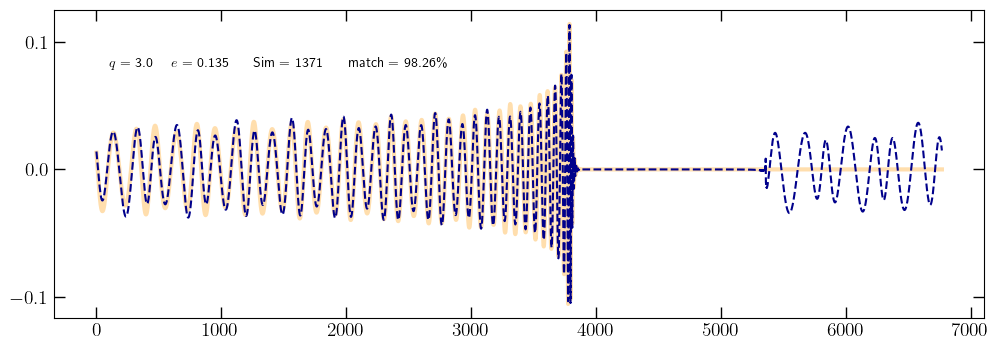

In [95]:
NR_stackup([17.344395747732634,0.134966397088076,-1.237627731038013])